In [1]:
# Zach's attempt to download and plot ATLfaux6 data from ICESat-2.
# Objectives: Download IS-2 data over Grand Mesa, and convert useful data into xarray structure

In [33]:
# imports:
import numpy as np
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import os
from IPython.display import Image
from IPython.core.display import HTML 
import hvplot.xarray
import pandas as pd
import rioxarray
import s3fs

In [34]:
# GDAL environment variables to efficiently read remote data
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

# SAR Data are stored in a public S3 Bucket
url = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# These Cloud-Optimized-Geotiff (COG) files have 'overviews', low-resolution copies for quick visualization
XR=[725000.0, 767000.0]
YR=[4.30e6, 4.34e6]
# open the dataset
da = rioxarray.open_rasterio(url, overview_level=1).squeeze('band')#.clip_box([712410.0, 4295090.0, 797010.0, 4344370.0])
da=da.where((da.x>XR[0]) & (da.x < XR[1]), drop=True)
da=da.where((da.y>YR[0]) & (da.y < YR[1]), drop=True)
dx=da.x[1]-da.x[0]
SAR_extent=[da.x[0]-dx/2, da.x[-1]+dx/2, np.min(da.y)-dx/2, np.max(da.y)+dx/2]

# Prepare coordinate transformations into the basemap coordinate system
from pyproj import Transformer, CRS
crs=CRS.from_wkt(da['spatial_ref'].spatial_ref.crs_wkt)
to_image_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lon, corners_lat=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
lonlims=[np.min(corners_lat), np.max(corners_lat)]
latlims=[np.min(corners_lon), np.max(corners_lon)]

In [35]:
import requests
import icepyx as ipx

region_a = ipx.Query('ATL03', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-12-01','2021-06-01'], \
                          start_time='00:00:00', end_time='23:59:59')

In [36]:
earthdata_uid = 'zhfair'
email = 'zhfair@umich.edu'
region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ·················


In [39]:
ATLAS_re=re.compile('ATL.._(?P<year>\d\d\d\d)(?P<month>\d\d)(?P<day>\d\d)\d+_(?P<track>\d\d\d\d)')
region_a.avail_granules()
date_track=[]
for count, item in enumerate(region_a.granules.avail):
    granule_info=ATLAS_re.search(item['producer_granule_id']).groupdict()
    date_track += [ ('-'.join([granule_info[key] for key in ['year', 'month', 'day']]), granule_info['track'])]

# print the first ten dates and ground tracks, plus their indexes
[(count, dt) for count, dt in enumerate(date_track[0:10])]

[(0, ('2018-12-13', '1156')),
 (1, ('2018-12-14', '1179')),
 (2, ('2019-01-11', '0211')),
 (3, ('2019-01-16', '0295')),
 (4, ('2019-02-09', '0653')),
 (5, ('2019-02-13', '0714')),
 (6, ('2019-02-14', '0737')),
 (7, ('2019-03-14', '1156')),
 (8, ('2019-03-15', '1179')),
 (9, ('2019-04-12', '0211'))]

In [32]:
import pandas as pd
from sliderule import icesat2

# initialize
icesat2.init("icesat2sliderule.org", verbose=False)

# region of interest polygon
region = [ {"lon":lon_i, "lat":lat_i} for lon_i, lat_i in 
          zip(np.array(lonlims)[[0, -1, -1, 0, 0]],  np.array(latlims)[[0, 0, -1, -1, 0]])]

# request parameters
params = {
    "poly": region,  # request the polygon defined by our lat-lon bounds
    "srt": icesat2.SRT_LAND, # request classification based on the land algorithm
    "cnf": icesat2.CNF_SURFACE_MEDIUM, # use all photons of low confidence or better
    "len": 20.0,  # fit data in overlapping 40-meter segments
    "res": 10.0,  # report one height every 20 m
    "ats":5., #report a segment only if it contains at least 2 photons separated by 5 m
    "maxi": 6,  # allow up to six iterations in fitting each segment to the data
}

# make request
rsps = icesat2.atl06p(params, "atlas-s3")

# save the result in a dataframe
df = pd.DataFrame(rsps)

# calculate the polar-stereographic coordinates:
df['x'], df['y']=to_image_crs.transform(df['lat'], df['lon'])

unable to process resource ATL03_20190717092724_02950402_003_01.h5: no elements
unable to process resource ATL03_20190711215129_02110406_003_01.h5: no elements
unable to process resource ATL03_20190412021205_02110306_003_01.h5: no elements
unable to process resource ATL03_20190614105952_11790302_003_01.h5: no elements
unable to process resource ATL03_20191108160740_06530506_003_01.h5: no elements
unable to process resource ATL03_20181110092841_06530106_003_01.h5: no elements
unable to process resource ATL03_20200109131121_02110606_003_01.h5: no elements
unable to process resource ATL03_20190209050825_06530206_003_01.h5: no elements
unable to process resource ATL03_20191016050727_02950502_003_01.h5: no elements
unable to process resource ATL03_20200207114722_06530606_003_01.h5: no elements
unable to process resource ATL03_20200508072713_06530706_003_01.h5: no elements
unable to process resource ATL03_20190111063212_02110206_003_01.h5: no elements
unable to process resource ATL03_2019051

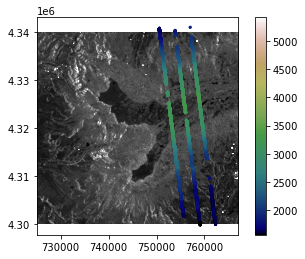

In [9]:
plt.figure(); 
plt.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])#plt.figure();
ii=(df['rgt']==737) & (df['cycle']==6)
plt.scatter(df['x'][ii], df['y'][ii],4, c=df['h_mean'][ii], cmap='gist_earth')
plt.colorbar()

Text(0, 0.5, 'height, m')

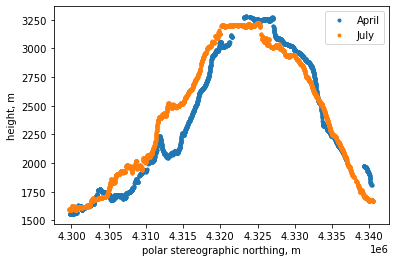

In [16]:
plt.figure();
ii=(df['rgt']==737) & (df['cycle']==6) & (df['spot']==3)
plt.plot(df['y'][ii], df['h_mean'][ii],'.', label='February')
ii=(df['rgt']==737) & (df['cycle']==8) & (df['spot']==3)
plt.plot(df['y'][ii], df['h_mean'][ii],'.', label='July') # Don't actually know if this is July; can't view the dates!

plt.legend()

plt.xlabel('polar stereographic northing, m')
plt.ylabel('height, m')

In [40]:
df.keys()

Index(['__rectype', 'cycle', 'rms_misfit', 'segment_id', 'spot', 'dh_fit_dy',
       'h_mean', 'lon', 'w_surface_window_final', 'dh_fit_dx', 'delta_time',
       'rgt', 'lat', 'pflags', 'n_fit_photons', 'h_sigma', 'x', 'y'],
      dtype='object')

In [12]:
import xarray



In [36]:
atlfaux6

<xarray.DataArray 'h_mean' (lat: 353166)>
array([2204.97455683, 2203.8735999 , 1710.04725504, ..., 1721.13212172,
       1727.04260109, 1733.70612996])
Coordinates:
  * lat      (lat) float64 38.97 38.97 38.83 38.91 ... 39.18 39.18 39.18 39.18

AttributeError: module 'icepyx.core' has no attribute 'read'